In [1]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from math import sqrt
import math
import numpy as np
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from Energy_Models import Models as mo
from Data import preprocess_data as pr

In [2]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.shape

(2075259, 7)

In [6]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [8]:
fill_missing(df.values)

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# Compute remaining active power
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [11]:
# descriptive statistics
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [12]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [13]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [14]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [15]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [16]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [17]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_UNI_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [18]:
# Split the testing data into input features and out feature
X_test, Y_test = pr.convert_UNI_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [30]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
model=mo.TCN_Model().getModel(n_steps,n_features,1)
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=100, batch_size=100, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/100
9/9 [==============================] - 3s 70ms/step - loss: 0.0744 - val_loss: 0.0087
Epoch 2/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0259 - val_loss: 0.0116
Epoch 3/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0218 - val_loss: 0.0073
Epoch 4/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0197 - val_loss: 0.0060
Epoch 5/100
9/9 [==============================] - 0s 34ms/step - loss: 0.0181 - val_loss: 0.0072
Epoch 6/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0211 - val_loss: 0.0056
Epoch 7/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0203 - val_loss: 0.0055
Epoch 8/100
9/9 [==============================] - 0s 34ms/step - loss: 0.0195 - val_loss: 0.0074
Epoch 9/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0183 - val_loss: 0.0077
Epoch 10/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0188 - val_loss: 0.0064


In [31]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0122
evaluation : 0.012 
14/14 [==============================] - 0s 5ms/step - loss: 0.0068
evaluation : 0.007 


In [32]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

14/14 [==============================] - 0s 5ms/step


In [33]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.110 
Train MSE value    : 0.012 
Train R2 value     : 0.396 
Train MAPE value   : 607131895321.653 
Train RMLSE value  : 0.007 
Train MAE value    : 0.085 
---------------------------------------------
Test RMSE value   : 0.082 
Test MSE value   : 0.007 
Test R2 value   : 0.382 
Test MAPE value  : 0.304 
Test RMLSE value  : 0.004 
Test MAE value : 0.065 


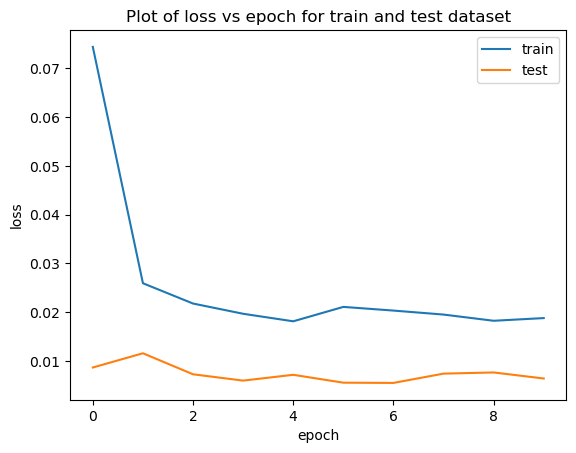

In [34]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [36]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [37]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_Multi_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [38]:
X_test, Y_test = pr.convert_Multi_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [40]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
model=mo.TCN_Model().getModel(n_steps,n_features,n_outputs)
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=200, batch_size=128, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/200
7/7 [==============================] - 3s 191ms/step - loss: 0.1429 - val_loss: 0.0112
Epoch 2/200
7/7 [==============================] - 1s 137ms/step - loss: 0.0366 - val_loss: 0.0082
Epoch 3/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0308 - val_loss: 0.0096
Epoch 4/200
7/7 [==============================] - 1s 138ms/step - loss: 0.0275 - val_loss: 0.0082
Epoch 5/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0266 - val_loss: 0.0087
Epoch 6/200
7/7 [==============================] - 1s 138ms/step - loss: 0.0244 - val_loss: 0.0082
Epoch 7/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0246 - val_loss: 0.0083
Epoch 8/200
7/7 [==============================] - 1s 141ms/step - loss: 0.0234 - val_loss: 0.0084
Epoch 9/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0235 - val_loss: 0.0082
Epoch 10/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0231 - val_loss: 0.0064
Epoch 11/

7/7 [==============================] - 1s 143ms/step - loss: 0.0127 - val_loss: 0.0059
Epoch 84/200
7/7 [==============================] - 1s 143ms/step - loss: 0.0126 - val_loss: 0.0061
Epoch 85/200
7/7 [==============================] - 1s 144ms/step - loss: 0.0126 - val_loss: 0.0077
Epoch 86/200
7/7 [==============================] - 1s 144ms/step - loss: 0.0128 - val_loss: 0.0087
Epoch 87/200
7/7 [==============================] - 1s 142ms/step - loss: 0.0130 - val_loss: 0.0069


In [47]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.0091
evaluation : 0.009 
13/13 [==============================] - 0s 2ms/step - loss: 0.0083
evaluation : 0.008 


In [48]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

13/13 [==============================] - 0s 2ms/step


In [49]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.095 
Train MSE value    : 0.009 
Train R2 value     : 0.517 
Train MAPE value   : 234429386422.531 
Train RMLSE value  : 0.005 
Train MAE value    : 0.072 
---------------------------------------------
Test RMSE value   : 0.091 
Test MSE value   : 0.008 
Test R2 value   : 0.282 
Test MAPE value  : 0.248 
Test RMLSE value  : 0.005 
Test MAE value : 0.069 


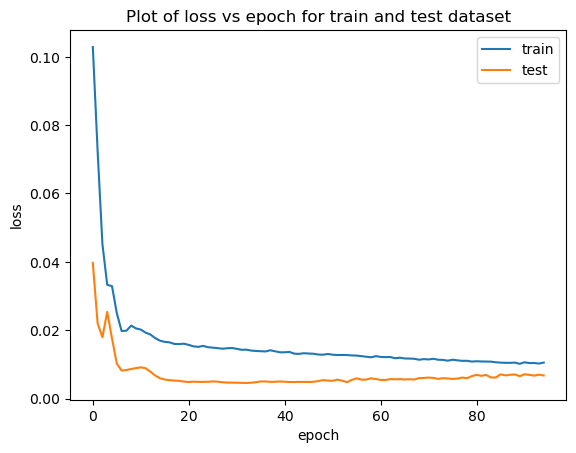

In [50]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()